# Cloud identification in photograph, then buoyancy and BPGF computation


In [1]:
# Import modules and load fields
import sys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import urllib

In [2]:
# Read image 
import imageio
im = imageio.imread('cloud_id_image.jpg')

# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

### CAREFUL! For images, the y (short) dimension appears to come first
NX = im_gray.shape[1]
NY = im_gray.shape[0]

Original image shape: (543, 1153, 3)
New image shape: (543, 1153)


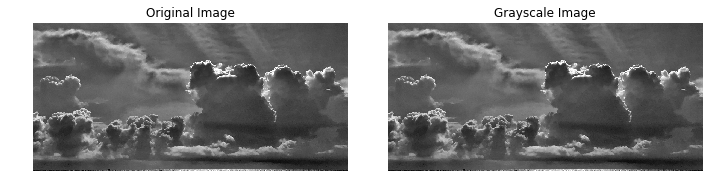

In [3]:
# Now, let's plot the data

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

Edge-based segmentation
=======================

Get the edges of features using the Canny edge-detector... However, this method is not very robust, since contours that are not perfectly closed are not filled correctly, as is the case for one unfilled coin above. [from scikit-image](https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html)



However, this method is not very robust, since contours that are not
perfectly closed are not filled correctly, as is the case for one unfilled
coin above.

Region-based segmentation
=========================

We therefore try a region-based method using the watershed transform.
First, we find an elevation map using the Sobel gradient of the image.



(-0.5, 1152.5, 542.5, -0.5)

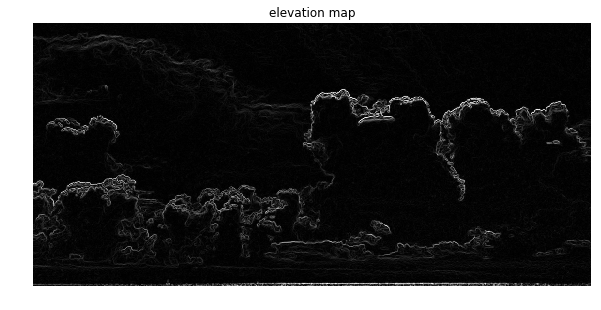

In [4]:
from skimage.filters import sobel

elevation_map = sobel(im_gray)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')

Next we find markers of the background and the coins based on the extreme
parts of the histogram of gray values.



(-0.5, 1152.5, 542.5, -0.5)

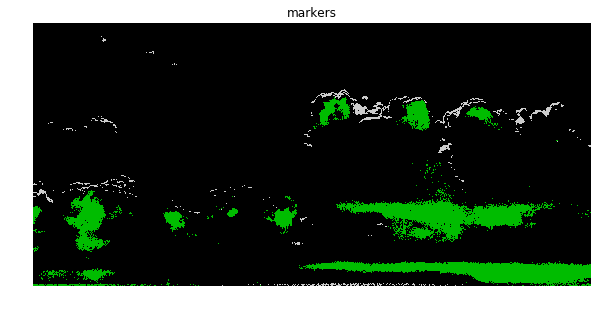

In [5]:
markers = np.zeros_like(im_gray)
markers[im_gray < 0.21] = 1 # image is continuous in [0,1]
markers[im_gray > 0.8] = 2

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')

Finally, we use the watershed transform to fill regions of the elevation
map starting from the markers determined above:



(-0.5, 1152.5, 542.5, -0.5)

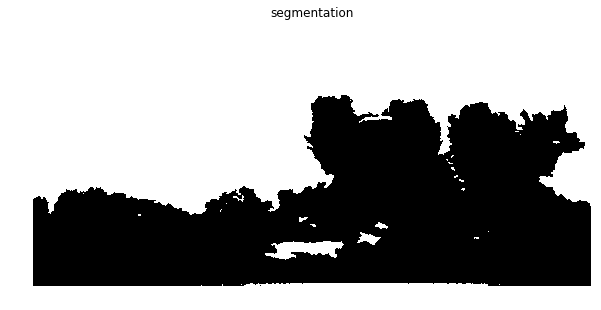

In [7]:
from skimage import morphology
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')

This last method works even better, and the coins can be segmented and
labeled individually.



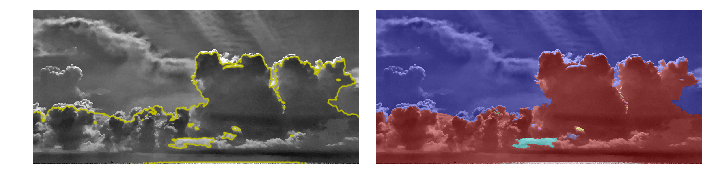

In [9]:
from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=im_gray)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes[0].imshow(im_gray, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

(543, 792)

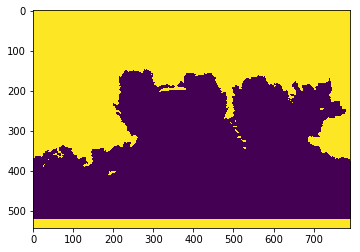

In [10]:
buoyblock = segmentation.copy()
block = buoyblock[:,361:]
block[410:,:] = False
block[520:,:] = True
plt.imshow(block)
np.shape(block)

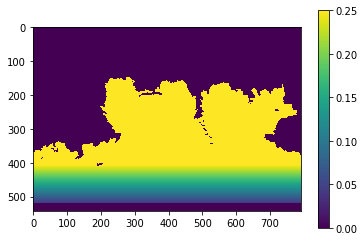

In [11]:
b = 1.0-block
nz,nx = np.shape(b)
z = np.arange(nz)
zz = z[:,None]

b = np.clip( b*(zz.max()-zz)/zz.max(), 0, 0.25) 
plt.imshow(b); plt.colorbar()

Text(0.5,1,'buoyancy for calculation')

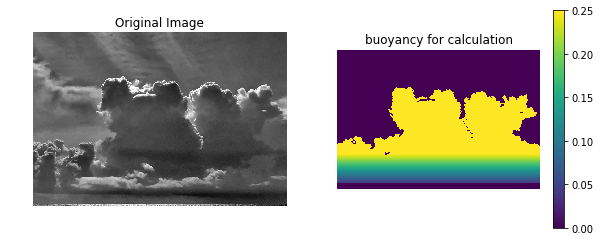

In [12]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im[:,361:])
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(b); plt.colorbar()
plt.axis('off')
plt.title('buoyancy for calculation')


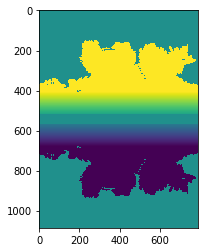

In [13]:
bflip = np.flip(b, axis=0)
bb = np.concatenate( (b,-bflip), axis=0)
plt.imshow(bb)

<a name="fft"></a>
## FFT and a quick look  


In [14]:
from numpy import fft

Text(0.5,1,'reconstructed -- huh? sign?')

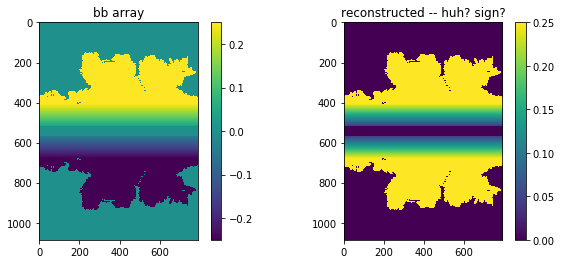

In [69]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(bb); plt.colorbar()
plt.title('bb array')

bhat = fft.fft2(bb)
brec = fft.ifft2(bhat)

plt.subplot(1,2,2)
plt.imshow(np.abs(brec)); plt.colorbar()
plt.title('reconstructed -- huh? sign?')


//anaconda/envs/drilsdown/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


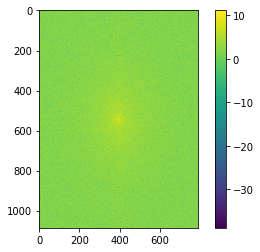

In [18]:
## Power spectrum abs(fft)
# Quick look: log, and shift origin to center of image
power = np.abs(bhat)
plt.imshow( np.log(fft.fftshift(power)) ); plt.colorbar()

In [19]:
shape = np.shape(bhat)
NX = shape[1]
NY = shape[0]
print('NX, NY ', NX, NY)

NX, NY  792 1086


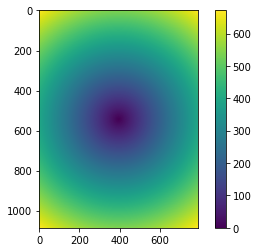

In [20]:
# Wavenumbers k, l in x,y directions: CYCLES PER DOMAIN

k = np.arange(NX) - NX/2
l = np.arange(NY) -NY/2

# Make 2D arrays of them 
kk, ll = np.meshgrid(k,l)

# Total wavenumber (distance from origin)
klshift = np.sqrt(kk**2 + ll**2)
plt.imshow( klshift ); plt.colorbar()

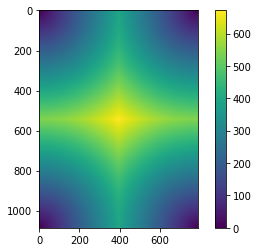

In [21]:
kl = np.clip( fft.fftshift(klshift), 0.5, 1e6)

plt.imshow( fft.fftshift(klshift) ); plt.colorbar()

Text(0.5,1,'Inverse Laplacian filtered')

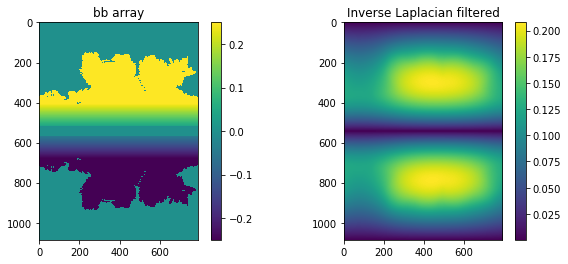

In [22]:
# Inverse Laplacian filter: ifft( fft() /k/k )
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(bb); plt.colorbar()
plt.title('bb array')

bhat = fft.fft2(bb)
brec = fft.ifft2(bhat /kl/kl )

plt.subplot(1,2,2)
plt.imshow(np.abs(brec)); plt.colorbar()
plt.title('Inverse Laplacian filtered')


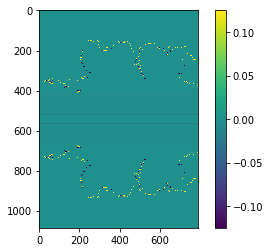

In [92]:
# Looks like it works. Now I need the inverse Laplacian of db/dz
dbdz = np.gradient(bb, axis=0)
plt.imshow( dbdz ); plt.colorbar()

Text(0.5,1,'Buoyancy pressure')

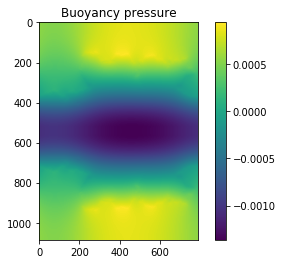

In [101]:
bpres = np.real(  fft.ifft2( fft.fft2(dbdz)/kl/kl )  )

plt.imshow(bpres); plt.colorbar()
plt.title('Buoyancy pressure')

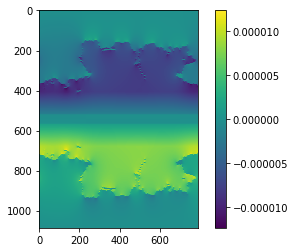

In [25]:
bpgf = np.gradient(bpres, axis=0)
plt.imshow(bpgf); plt.colorbar()

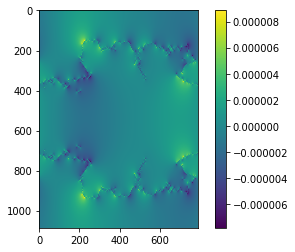

In [74]:
bpgfz, bpgfx = np.gradient(bpres)
plt.imshow(bpgfx); plt.colorbar()

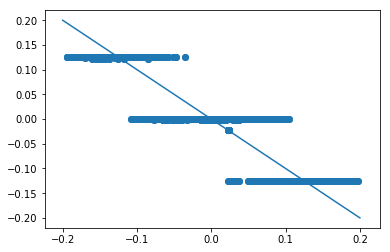

In [113]:
# Divergence of BPGF 
divBPGF = np.gradient(bpgfz, axis=0) + np.gradient(bpgfx, axis=1)
plt.scatter(divBPGF *4.5e4, dbdz)
plt.plot([0.2,-0.2], [-0.2,0.2]) # one to one line

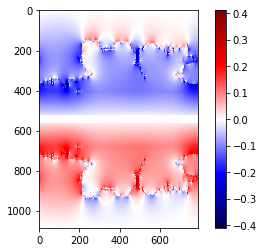

In [114]:
# Need to rescale the PGF but absolute value got lost in this ifft because wavenumber units ugh

totalforce = bb + bpgf*4.5e4
plt.imshow(totalforce, cmap='seismic'); plt.colorbar()

In [26]:
np.shape(b)

(543, 792)

In [27]:
bpgf1 = bpgf[0:543,:]
np.shape(bpgf1)

(543, 792)

Text(0.5,1,'BPGF')

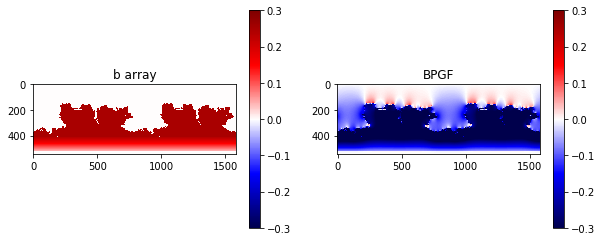

In [116]:
plt.figure(figsize=(10,4))

b_periodic = np.concatenate((b,b), axis=1)
bpgf_periodic = np.concatenate((bpgf1,bpgf1), axis=1)


plt.subplot(1,2,1)
plt.imshow( b_periodic, cmap='seismic', vmin = -0.3, vmax=0.3  ); plt.colorbar()
plt.title('b array')

plt.subplot(1,2,2)
plt.imshow( bpgf_periodic*4.5e4, cmap='seismic', vmin = -0.3, vmax=0.3 )
plt.colorbar()
plt.title('BPGF')

In [68]:
np.max(b)/np.min(bpgf_periodic)

-20283.31577903987

Text(0.5,1,'Total vertical force: b + BPGF')

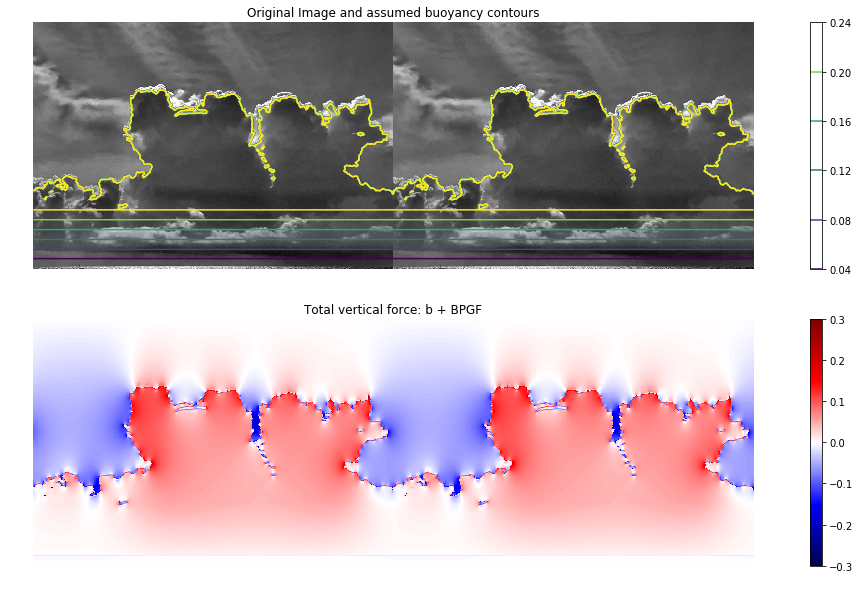

In [119]:
# Total of the 2 forces. There's a rescaling here... DAMMIT 4.5e4 from scatterplot is not right 
# rather ad hoc since my wavenumber array and ifft depends on fft conventions too hoary to check

totalvforce = b_periodic + bpgf_periodic *2.6e4 # * np.max(b)/np.min(bpgf_periodic)
#totalvforce -= np.mean(totalvforce)

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.imshow( np.concatenate((im[:,361:],im[:,361:]),axis=1) )
plt.contour(b_periodic); plt.colorbar()
plt.axis('off')
plt.title('Original Image and assumed buoyancy contours')


plt.subplot(2,1,2)

plt.imshow( totalvforce, cmap='seismic', vmin = -0.3, vmax=0.3); plt.colorbar()
plt.axis('off')
plt.title('Total vertical force: b + BPGF')
